In [1]:
# Mid-Price Prediction based on Limit Order Book
# Author: Jovad Uribe
# Description: Predicting the mid price using the best mid and ask volume, and bid/ask depth
# Hurdles: Processing, cleaning, and training large sets of data

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
import math
import wget
import gzip
import json
import json
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import dask
import dask.dataframe
import dask.array as da
from dask.distributed import Client

dd = dask.dataframe
client = Client(processes=False)

In [3]:
day1 = "http://im-md-public.s3-website-ap-northeast-1.amazonaws.com/market_data_binance_btcusdt_test/binance-btcusdt-2021-02-01.gz"
day2 = "http://im-md-public.s3-website-ap-northeast-1.amazonaws.com/market_data_binance_btcusdt_test/binance-btcusdt-2021-02-02.gz"
day3 = "http://im-md-public.s3-website-ap-northeast-1.amazonaws.com/market_data_binance_btcusdt_test/binance-btcusdt-2021-02-03.gz"
day4 = "http://im-md-public.s3-website-ap-northeast-1.amazonaws.com/market_data_binance_btcusdt_test/binance-btcusdt-2021-02-04.gz"
day5 = "http://im-md-public.s3-website-ap-northeast-1.amazonaws.com/market_data_binance_btcusdt_test/binance-btcusdt-2021-02-05.gz"
day6 = "http://im-md-public.s3-website-ap-northeast-1.amazonaws.com/market_data_binance_btcusdt_test/binance-btcusdt-2021-02-06.gz"
day7 = "http://im-md-public.s3-website-ap-northeast-1.amazonaws.com/market_data_binance_btcusdt_test/binance-btcusdt-2021-02-07.gz"
day8 = "http://im-md-public.s3-website-ap-northeast-1.amazonaws.com/market_data_binance_btcusdt_test/binance-btcusdt-2021-02-08.gz"
day9 = "http://im-md-public.s3-website-ap-northeast-1.amazonaws.com/market_data_binance_btcusdt_test/binance-btcusdt-2021-02-09.gz"

In [4]:
allLinks = [day1, day2, day3, day4, day5, day6, day7, day8, day9]

In [5]:
for link in allLinks:
    wget.download(link)

In [5]:
df1 = dd.read_csv('binance-btcusdt-2021-02-01.gz', blocksize=25e6, compression='gzip', header=0, sep=' ', quotechar='"', error_bad_lines=False)
df2 = dd.read_csv('binance-btcusdt-2021-02-02.gz', blocksize=25e6, compression='gzip', header=0, sep=' ', quotechar='"', error_bad_lines=False)
df3 = dd.read_csv('binance-btcusdt-2021-02-03.gz', blocksize=25e6, compression='gzip', header=0, sep=' ', quotechar='"', error_bad_lines=False)
df4 = dd.read_csv('binance-btcusdt-2021-02-04.gz', blocksize=25e6, compression='gzip', header=0, sep=' ', quotechar='"', error_bad_lines=False)
df5 = dd.read_csv('binance-btcusdt-2021-02-05.gz', blocksize=25e6, compression='gzip', header=0, sep=' ', quotechar='"', error_bad_lines=False)
df6 = dd.read_csv('binance-btcusdt-2021-02-06.gz', blocksize=25e6, compression='gzip', header=0, sep=' ', quotechar='"', error_bad_lines=False)
df7 = dd.read_csv('binance-btcusdt-2021-02-07.gz', blocksize=25e6, compression='gzip', header=0, sep=' ', quotechar='"', error_bad_lines=False)
df8 = dd.read_csv('binance-btcusdt-2021-02-08.gz', blocksize=25e6, compression='gzip', header=0, sep=' ', quotechar='"', error_bad_lines=False)
df9 = dd.read_csv('binance-btcusdt-2021-02-09.gz', blocksize=25e6, compression='gzip', header=0, sep=' ', quotechar='"', error_bad_lines=False)

C:\Users\jovur\Anaconda3\lib\site-packages\dask\dataframe\io\csv.py:462: UserWarning: Warning gzip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  warn(


In [6]:
# Change column names
frames = [df1,df2,df3,df4,df5,df6,df7,df8,df9]
for d_f in frames:
    d_f.columns = ['Time', 'Bid/Ask']

In [7]:
# Clean and organize data into one dataframe

midDf = []
for df_f in frames:
    dates = []
    mids = []
    askVols = []
    bidVols = []
    ask = []
    bid = []
    askDepth = []
    bidDepth = []
    iterations = 0
    for row in df_f.iterrows():
        cur = json.loads(row[1][1])
        if ((len(cur["bids"]) == 0) or (len(cur["asks"]) == 0)): 
            continue
        iterations += 1
        mids.append((cur["bids"][0][0] + cur["asks"][0][0])/2)
        askVols.append(cur["bids"][0][1])
        bidVols.append(cur["asks"][0][1])
        bid.append(cur["bids"][0][0])
        ask.append(cur["asks"][0][0])
        bidDepth.append(len(cur["bids"]))
        askDepth.append(len(cur["asks"]))
        dates.append(row[1][0])
    
    mDf_ = pd.DataFrame(zip(dates, bid, ask, mids, askVols, bidVols, bidDepth, askDepth), columns=['Date', 'Bid', 'Ask', 'Mid', 'AskVols', 'BidVols', 'BidDepth', 'AskDepth'])
    mDf_.set_index(['Date'], inplace=True)
    
    midDf.append(mDf_)

In [40]:
# Concat list of dataframes
dfM = pd.concat(midDf, axis=0)
dfM.head()

,Bid,Ask,Mid,AskVols,BidVols,BidDepth,AskDepth
Date,,,,,,,
2021-02-01T00:02:47.05047,32887.91,32897.63,32892.770,0.015214,0.680750,10,25
2021-02-01T00:02:48.00938,32881.76,32891.83,32886.795,0.400000,0.001027,23,24
2021-02-01T00:02:49.05243,32884.48,32884.64,32884.560,0.215450,2.697897,22,25
2021-02-01T00:02:50.05194,32881.46,32881.47,32881.465,0.002000,2.190389,22,24
2021-02-01T00:02:51.00492,32885.19,32886.70,32885.945,0.400000,2.000000,25,25


<AxesSubplot:title={'center':'Best Bid/Ask/Mid Prices'}, xlabel='Time', ylabel='Price'>

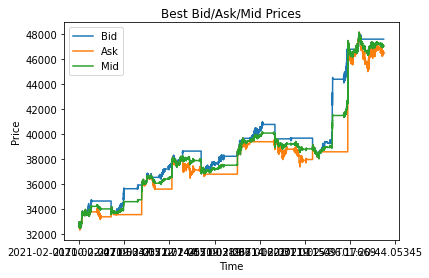

In [36]:
dfM[["Bid", "Ask", "Mid"]].plot(title="Best Bid/Ask/Mid Prices", xlabel="Time", ylabel="Price")

<AxesSubplot:title={'center':'Amount of Shares Purchased at Best Bid/Ask'}, xlabel='Time', ylabel='Shares purchased'>

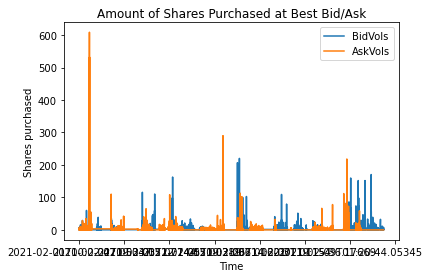

In [37]:
dfM[["BidVols", "AskVols"]].plot(title = "Amount of Shares Purchased at Best Bid/Ask", xlabel="Time", ylabel="Shares purchased")

<AxesSubplot:title={'center':'Bid/Ask Depth'}, xlabel='Time', ylabel='Depth'>

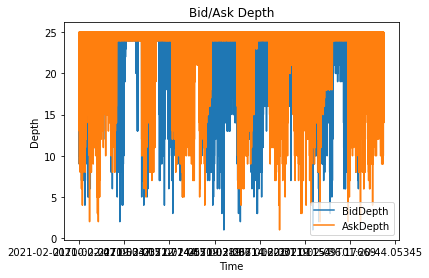

In [38]:
dfM[["BidDepth", "AskDepth"]].plot(title = "Bid/Ask Depth", xlabel="Time", ylabel="Depth")

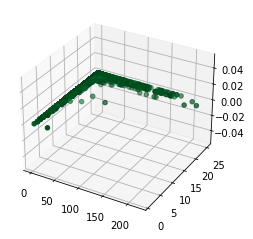

In [58]:
# How does Bid Depth and Best Bid Volume compare?

fig = plt.figure()
bidPlot = fig.add_subplot(111, projection='3d')
z = dfM["BidDepth"]
y = dfM["BidVols"]
bidPlot.scatter3D(y, z, c = zline, cmap='Greens')

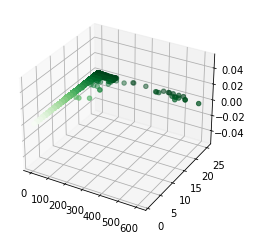

In [59]:
# How does Ask Depth and Best Ask Volume compare?

fig = plt.figure()
askPlot = fig.add_subplot(111, projection='3d')
z = dfM["AskDepth"]
y = dfM["AskVols"]
askPlot.scatter3D(y, z, c = zline, cmap='Greens')

In [43]:
df = pd.DataFrame(data = dfM)

In [44]:
df.tail()

,Bid,Ask,Mid,AskVols,BidVols,BidDepth,AskDepth
Date,,,,,,,
2021-02-10T00:02:24.02510,47575.68,46390.24,46982.960,0.023482,0.005772,24,22
2021-02-10T00:02:25.02504,47575.68,46392.06,46983.870,0.023482,0.188596,25,25
2021-02-10T00:02:26.10214,47575.68,46394.67,46985.175,0.023482,0.198310,25,25
2021-02-10T00:02:27.03175,47575.68,46402.38,46989.030,0.023482,1.144001,25,24
2021-02-10T00:02:28.02819,47575.68,46418.56,46997.120,0.023482,1.270000,24,24


In [45]:
testSize = 0.20
numberOfPredictions = math.ceil(len(df["Mid"])*testSize)
df["Prediction"] = df[["Mid"]].shift(-numberOfPredictions)
df.tail()

,Bid,Ask,Mid,AskVols,BidVols,BidDepth,AskDepth,Prediction
Date,,,,,,,,
2021-02-10T00:02:24.02510,47575.68,46390.24,46982.960,0.023482,0.005772,24,22,NaN
2021-02-10T00:02:25.02504,47575.68,46392.06,46983.870,0.023482,0.188596,25,25,NaN
2021-02-10T00:02:26.10214,47575.68,46394.67,46985.175,0.023482,0.198310,25,25,NaN
2021-02-10T00:02:27.03175,47575.68,46402.38,46989.030,0.023482,1.144001,25,24,NaN
2021-02-10T00:02:28.02819,47575.68,46418.56,46997.120,0.023482,1.270000,24,24,NaN


In [47]:
# Prepare data for models

tree = DecisionTreeRegressor()
reg = LinearRegression()
X = np.array(df.drop(["Prediction","Ask", "Bid", "Mid"], 1))[:-numberOfPredictions]
y = np.array(df["Prediction"])[:-numberOfPredictions]
testX = df.drop(["Prediction", "Ask", "Bid", "Mid"], 1)[:-numberOfPredictions]
testX = testX.tail(numberOfPredictions)
testX = np.array(testX)

In [48]:
with joblib.parallel_backend('dask'):
    tree.fit(X, y)
    reg.fit(X, y)
linearPredict = reg.predict(testX)
treePredict = tree.predict(testX)

In [49]:
valid = df[X.shape[0]:]
valid["Linear Prediction"] = linearPredict
valid["Tree Prediction"] = treePredict

<ipython-input-49-c66ff139c6f9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Linear Prediction"] = linearPredict
<ipython-input-49-c66ff139c6f9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Tree Prediction"] = treePredict


<AxesSubplot:title={'center':'Decision Tree'}, xlabel='Date'>

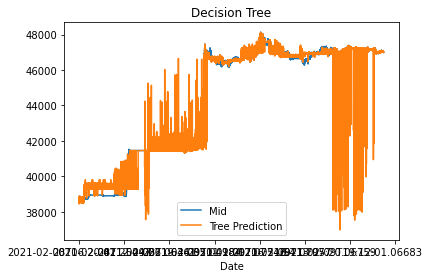

In [50]:
valid[["Mid", "Tree Prediction"]].plot(title="Decision Tree")

<AxesSubplot:title={'center':'Linear Regression'}, xlabel='Date'>

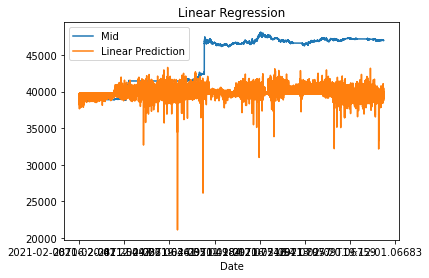

In [51]:
valid[["Mid", "Linear Prediction"]].plot(title = "Linear Regression")

<AxesSubplot:title={'center':'Total Plot Decision Tree'}>

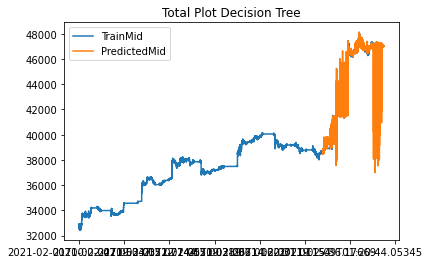

In [52]:
treeWithOld = pd.DataFrame(data={"TrainMid":df["Mid"], "PredictedMid":valid["Tree Prediction"]})
treeWithOld.plot(title="Total Plot Decision Tree")

<AxesSubplot:title={'center':'Total Plot Linear Regression'}>

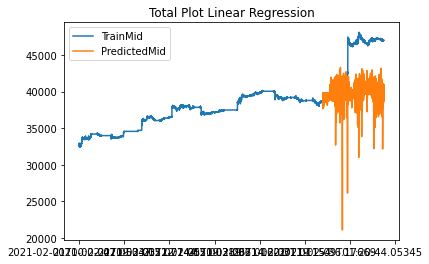

In [53]:
linearWithOld = pd.DataFrame(data={"TrainMid":df["Mid"], "PredictedMid":valid["Linear Prediction"]})
linearWithOld.plot(title="Total Plot Linear Regression")

In [54]:
print('Decision Tree - Mean Absolute Error:', metrics.mean_absolute_error(valid["Mid"], treePredict))  
print('Decision Tree - Mean Squared Error:', metrics.mean_squared_error(valid["Mid"], treePredict))  
print('Decision Tree - Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(valid["Mid"], treePredict)))
print('Linear Regression - Mean Absolute Error:', metrics.mean_absolute_error(valid["Mid"], linearPredict))  
print('Linear Regression - Mean Squared Error:', metrics.mean_squared_error(valid["Mid"], linearPredict))  
print('Linear Regression - Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(valid["Mid"], linearPredict)))

Decision Tree - Mean Absolute Error: 199.39634566850194
Decision Tree - Mean Squared Error: 250026.9205780484
Decision Tree - Root Mean Squared Error: 500.02691985336986
Linear Regression - Mean Absolute Error: 4742.643488713339
Linear Regression - Mean Squared Error: 30964929.10619431
Linear Regression - Root Mean Squared Error: 5564.614012327747


In [55]:
features = ["AskVols", "BidVols", "AskDepth", "BidDepth"]
finalTest = pd.DataFrame(data= dfM.iloc[-1][features])
finalTest = finalTest.T
finalTest

,AskVols,BidVols,AskDepth,BidDepth
2021-02-10T00:02:28.02819,0.023482,1.27,24.0,24.0


In [56]:
pred = tree.predict(finalTest)

In [57]:
print("Predicted next mid price: " + str(pred))

Predicted next mid price: [36148.]
